# Udacity Data Analysis Nanodegree
# Project 3: Wrangling and Analyze Data

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing data](#assess)
- [Step 3: Cleaning](#cleaning)
- [Step 4: Storing Data](#storing)
- [Step 5: Analysing and Visualization](#visuals)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

This project was completed as part of the 'Data Analyst' nanodegree with Udacity. 

The goal of the project was to demonstrate the data wrangling and analysis skills obtained from the course.

The dataset to be wrangled is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. Dog owners upload a picture of their dog, writes a funny comment and give their own dog a rating out of 10. Owners almost always give their dogs a rating greater than 10. e.g 11/10, 12/10, 13/10, it's the nature of the website. WeRateDogs has over 4 million followers and has received international media coverage. It's only a bit of fun, and brings great joy when browsing the cutest dog images !

### Data

In this project, 3 datasets needs to be gathered automatically, assessed and cleaned

4 data gathering strategies was demonstrated:

### 1. Twitter archive - Automated downloaded from an URL

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for a sample of 2356 tweets with ratings, for a period between Nov 2015 - July 2017.
Data was automatically downloaded from the Udacity website using `pd.read_csv` and passing the URL 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv' as input.

### 2. Use twitter API 'tweepy v2' to retrieve additional data

For each tweet in the twitter archive from step 1, the retweet and like count was retrieved as minimum requirement for the project

The latest version of the tweepy API was used to retrieve additional data, which offered more flexibility and data availability.

Each tweet's entire JSON response was dumped to a txt file, each tweet on its own line

The .txt file was read line by line, and the most useful data to be reused was added to a pandas dataframe. 

### 3. Use the Requests library to download the tweet breed predictions (image_predictions.tsv)

Udacity provided a file that used the dog images to predict the breed of the dog.
Each tweet consist of the link to the image that gave the best predictions, 3 predictions, each with it's confidence level and if the prediction is actually a valid dog breed.

This file (image_predictions.tsv), is hosted on Udacity's servers and was downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


### 4. Download dog profile images (optional extra step)

Image urls containing `.jpg` retrieved from API in step 2 was used to download the first dog image for each tweet from the internet, as additional practice. I had in mind for visualization to show a dog profile card of the most liked breeds and dogs.

In [1]:
import pandas as pd
import numpy as np
import requests
import os
from io import BytesIO
import tweepy
import json
import time
from PIL import Image, ImageFont, ImageDraw
from IPython.display import HTML, display

import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# environment settings
pd.set_option('display.max_colwidth', None)

# stock scientific notation on graphs
pd.options.display.float_format = '{:.2f}'.format

Default data and functions

In [2]:
# general data directory
filename_general = '../data'

# twitter archive
filename_twitter_archive = '../data/twitter_archive_enhanced.csv'

# image predictions
folder_image_predictions = '../data/image_predictions'
filename_image_predictions = '../data/image_predictions/image_predictions.tsv'

# additional data from twitter API 
folder_twitter_api = '../data/json'
filename_twitter_api = '../data/json/tweet_json.txt'
filename_twitter_api_output = '../data/tweepy_api.csv'
filename_twitter_api_errors = '../data/tweepy_api_errors.txt'

# dog posters
folder_image_profiles = '../data/image_profiles'
filename_image_errors = '../data/json/api_missing_data_errors.txt'

In [3]:
def create_folder(folder_name):
    """ Make directory if it doesn't already exist """
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)    

In [4]:
def display_image(ds):
    """ display dog image with text
    
    Parameters:
       ds (series): entire row from twitter_archive_master.csv for the tweet we want to print a profile card for
    
    """
    
    image_path1 = ds.jpg_url
    
    # if an image breed prediction image is available use that as profile picture by default, 
    # otherwise use image downloaded from API
    filename = ''
    if ds.jpg_url:
        filename = best.jpg_url
    else:
        filename = '../data/image_profiles/' + str(ds.tweet_id) + '.jpg'
     
    nametext = ''
    if (ds['name'] == 'unknown') & (ds['annotation'] != ''):
        nametext = ds['annotation']  
    else:
        nametext = ds['name']   
        
    breedtext = ''
    if (ds['breed'] == 'unknown') & (ds['annotation'] != ''):
        breedtext = ds['annotation']  
    else:
        breedtext = ds['breed']         
        
        
    if filename:
        display(HTML(f"""
            <p>
                <img src={filename} alt={ds['tweet_id']} width=300 style="float:left">
                <h4>{ds['cleantext']}</h4><br>
                <em>Name: {nametext}</em><br>
                <em>Breed: {breedtext}</em><br>    
                <em>Dog stage: {ds['dog_stage']}</em><br>                 
                <em>Score: {ds['rating_numerator']}/{best['rating_denominator']}</em><br>
                <em>Likes : {ds['like_count']}</em><br>    
                <em>Retweets : {ds['retweet_count']}</em><br>  
                <em><a href={ds['short_url']}>{ds['short_url']}</a></em>
            </p>

            """))

<a id='datagathering'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Data Gathering</span>


In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

<span style="color:blue">1.1 Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)</span>

In [5]:
# Download file from Udacity server
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
df_twitter_archive = pd.read_csv(url)
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [6]:
df_twitter_archive.shape

(2356, 17)

In [7]:
# write WeRateDogs Twitter archive data to csv

# Make main data directory if it doesn't already exist
create_folder(filename_general)

df_twitter_archive.to_csv(filename_twitter_archive, index=False)

<span style="color:blue">1.2 Use the Requests library to download the tweet image prediction (image_predictions.tsv)</span>

In [8]:
# Make directory if it doesn't already exist
create_folder(folder_image_predictions)

In [9]:
# download and save image predictions
udacity_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(udacity_url)  

# save file 
with open(filename_image_predictions, mode = 'wb') as file:
    file.write(response.content)

Test if file was downloaded from Udacity server successfully

In [10]:
# check that a file was successful saved in the new directory
assert len(os.listdir(folder_image_predictions)) == 1

In [11]:
# load new file into a dataframe
df_image_predictions = pd.read_csv(filename_image_predictions, sep='\t')

Test if file was loaded into a dataframe successfully

In [12]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.47,True,collie,0.16,True,Shetland_sheepdog,0.06,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.51,True,miniature_pinscher,0.07,True,Rhodesian_ridgeback,0.07,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.60,True,malinois,0.14,True,bloodhound,0.12,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.41,True,redbone,0.36,True,miniature_pinscher,0.22,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.56,True,Rottweiler,0.24,True,Doberman,0.15,True


In [13]:
df_image_predictions.shape

(2075, 12)

<span style="color:blue">1.3 Use twitter API 'tweepy' to retrieve additional data</span>

For each twitter id in the twitter archive file from step 1.1, retrieve additional data from the API
Minimum requirement: retweet count, and favorite count

In [14]:
# import API credentials from environment variables
consumer_key = os.environ.get('TWITTER_CONSUMER_KEY')
consumer_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_secret = os.environ.get('TWITTER_ACCESS_SECRET')
bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

In [15]:
# download and save files

start_time = time.time()

# create a folder if it does not exist
create_folder(folder_twitter_api)
error_list = []
counter = 1
total_records = df_twitter_archive['tweet_id'].shape[0]

# Make a connection with API v2
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        access_token=access_token, 
                        access_token_secret=access_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

# write json file
with open(filename_twitter_api, 'w') as outfile:

    for tweet_id in df_twitter_archive['tweet_id']:

            # This cell is slow so print counter to gauge time remaining   
            if counter%50 == 0:
                print('Tweet: {}, {} out of {} tweets completed'.format(tweet_id, counter, total_records))

            # call get_tweets API
            tweet_fields = ["public_metrics", "entities", "text", "attachments","geo"]
            expansions = ['geo.place_id', 'attachments.media_keys']
            media_fields = ['url', 'type']
            place_fields = ['country_code', 'full_name', 'place_type']
            response = client.get_tweets(tweet_id, 
                                         tweet_fields=tweet_fields, 
                                         expansions=expansions,
                                         media_fields=media_fields,
                                         place_fields = place_fields)
            if response.status_code == 200:        
                # write tweet to file on it's own line
                json_string = json.dumps(response.json()) 
                outfile.write(json_string + '\n')

            else:
                # construct error message and append to error list
                error_message = "Request returned an error: {} {}".format(response.status_code, response.text)
                print(error_message)
                error_list.append(error_message)
                
            counter+=1
            
end_time = time.time()
print('Executing time: {}'.format(end_time - start_time))

Tweet: 882762694511734784, 50 out of 2356 tweets completed
Tweet: 872967104147763200, 100 out of 2356 tweets completed
Tweet: 863079547188785154, 150 out of 2356 tweets completed
Tweet: 854120357044912130, 200 out of 2356 tweets completed
Tweet: 845306882940190720, 250 out of 2356 tweets completed
Tweet: 836989968035819520, 300 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 836 seconds.


Tweet: 831650051525054464, 350 out of 2356 tweets completed
Tweet: 824796380199809024, 400 out of 2356 tweets completed
Tweet: 819004803107983360, 450 out of 2356 tweets completed
Tweet: 813127251579564032, 500 out of 2356 tweets completed
Tweet: 805207613751304193, 550 out of 2356 tweets completed
Tweet: 798682547630837760, 600 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 836 seconds.


Tweet: 792913359805018113, 650 out of 2356 tweets completed
Tweet: 786286427768250368, 700 out of 2356 tweets completed
Tweet: 779124354206535695, 750 out of 2356 tweets completed
Tweet: 772826264096874500, 800 out of 2356 tweets completed
Tweet: 766008592277377025, 850 out of 2356 tweets completed
Tweet: 758828659922702336, 900 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 836 seconds.


Tweet: 752309394570878976, 950 out of 2356 tweets completed
Tweet: 748220828303695873, 1000 out of 2356 tweets completed
Tweet: 743222593470234624, 1050 out of 2356 tweets completed
Tweet: 735991953473572864, 1100 out of 2356 tweets completed
Tweet: 726828223124897792, 1150 out of 2356 tweets completed
Tweet: 716791146589110272, 1200 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 831 seconds.


Tweet: 711306686208872448, 1250 out of 2356 tweets completed
Tweet: 707738799544082433, 1300 out of 2356 tweets completed
Tweet: 704134088924532736, 1350 out of 2356 tweets completed
Tweet: 699691744225525762, 1400 out of 2356 tweets completed
Tweet: 696100768806522880, 1450 out of 2356 tweets completed
Tweet: 692187005137076224, 1500 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 833 seconds.


Tweet: 689255633275777024, 1550 out of 2356 tweets completed
Tweet: 686034024800862208, 1600 out of 2356 tweets completed
Tweet: 683742671509258241, 1650 out of 2356 tweets completed
Tweet: 680970795137544192, 1700 out of 2356 tweets completed
Tweet: 679047485189439488, 1750 out of 2356 tweets completed
Tweet: 677187300187611136, 1800 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 833 seconds.


Tweet: 675781562965868544, 1850 out of 2356 tweets completed
Tweet: 674670581682434048, 1900 out of 2356 tweets completed
Tweet: 673689733134946305, 1950 out of 2356 tweets completed
Tweet: 672523490734551040, 2000 out of 2356 tweets completed
Tweet: 671504605491109889, 2050 out of 2356 tweets completed
Tweet: 670717338665226240, 2100 out of 2356 tweets completed


Rate limit exceeded. Sleeping for 831 seconds.


Tweet: 669684865554620416, 2150 out of 2356 tweets completed
Tweet: 668779399630725120, 2200 out of 2356 tweets completed
Tweet: 667861340749471744, 2250 out of 2356 tweets completed
Tweet: 667065535570550784, 2300 out of 2356 tweets completed
Tweet: 666051853826850816, 2350 out of 2356 tweets completed
Executing time: 6362.638165950775


In [16]:
# create .txt file containing API errors
if len(error_list) > 0:
    with open('../data/json/api_errors.txt', 'w') as outfile:
        outfile.write(str(error_list))

In [17]:
# read json file and import into a dataframe

selected_attr = []
error_list = []
counter=0

with open(filename_twitter_api, 'r') as json_file:
    for line in json_file:

        json_data = json.loads(line)
        
        # Extract "data" value from dictionary
        try:
            tweets_data = json_data['data'][0] 
            tweet_id = tweets_data['id']
            text = tweets_data['text']            
        except:
            message = ('Error for index {}: [data] not available could be tweet no longer exist'.format(counter))
            error_list.append(message)
            continue
        
        # get first image of dog
        try: 
            tweets_media = json_data['includes'] 
            media_url = tweets_media['media'][0]['url']
            media_type = tweets_media['media'][0]['type']  
        except:
            media_url = media_type = ''
            message = 'Error for index {}: media not available for tweet {}'.format(counter, tweet_id)
            error_list.append(message)

        # get public statistics e.g. retweet and like data
        try:
            retweet_count = tweets_data['public_metrics']['retweet_count']
            reply_count = tweets_data['public_metrics']['reply_count']
            like_count = tweets_data['public_metrics']['like_count']
            quote_count = tweets_data['public_metrics']['quote_count']   
        except:
            retweet_count = reply_count = like_count = quote_count = ''  
            message = ('Error for index {}: public statistics not available for tweet {}'.format(counter, tweet_id))   
            error_list.append(message)
                       
        # get first available urls
        try:
            short_url = tweets_data['entities']['urls'][0]['url']                              
            expanded_url = tweets_data['entities']['urls'][0]['expanded_url']    
        except:
            short_url = expanded_url = ''        
            message = ('Error for index {}: URL not available for tweet {}'.format(counter, tweet_id))   
            error_list.append(message)            
            
        
        # get first annotion to possibly pickup the name of the dog, if it exist 
        try:
            annotation = tweets_data['entities']['annotations'][0]['normalized_text'] 
        except:
            annotation = ''
            message = ('Error for index {}: Annotations not available for tweet {}'.format(counter, tweet_id)) 
            error_list.append(message)      

            
        selected_attr.append({"id": tweet_id,
                              "text": text,
                              "retweet_count": retweet_count,
                              "reply_count":  reply_count,
                              "like_count": like_count,
                              "quote_count": quote_count,
                              "media_url": media_url,
                              "media_type": media_type,                  
                              "short_url": short_url ,                      
                              "expanded_url": expanded_url,
                              "annotation": annotation
                             })
            
        counter+=1

In [18]:
#create dataframe
df_tweepy = pd.DataFrame(selected_attr)
df_tweepy.head()

,id,text,retweet_count,reply_count,like_count,quote_count,media_url,media_type,short_url,expanded_url,annotation
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,6847,135,32810,219,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,photo,https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",5153,162,28364,274,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,photo,https://t.co/0Xxu71qeIV,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,3403,108,21295,145,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,photo,https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,7057,139,35766,286,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,photo,https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",7566,192,34193,296,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,photo,https://t.co/AtUZn91f7f,https://twitter.com/dog_rates/status/891327558926688256/photo/1,Franklin


In [22]:
# create .txt file containing missing data problems we could not retrieve from the dumped json data
if len(error_list) > 0:
    with open(filename_twitter_api_errors, 'w') as outfile:
        outfile.write(str(error_list))

In [23]:
df_tweepy.to_csv('../data/tweepy_api.csv', index=False)

<span style="color:blue">1.4 Download dog profile images (optional extra step)</span>

In [6]:
df_tweepy = pd.read_csv(filename_twitter_api_output)
df_tweepy.head(5)            

,id,text,retweet_count,reply_count,like_count,quote_count,media_url,media_type,short_url,expanded_url,annotation
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,6847,135,32810,219,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,photo,https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",5153,162,28364,274,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,photo,https://t.co/0Xxu71qeIV,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,3403,108,21295,145,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,photo,https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,7057,139,35766,286,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,photo,https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",7566,192,34193,296,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,photo,https://t.co/AtUZn91f7f,https://twitter.com/dog_rates/status/891327558926688256/photo/1,Franklin


In [7]:
# retrieve dog posters

start_time = time.time()

df_list = []
image_errors = []
counter = 0
total_records = df_tweepy.shape[0]

  
# Make directory if it doesn't already exist
create_folder(folder_image_profiles)    

# Download images
for i in df_tweepy.index:
    
    url = df_tweepy['media_url'][i]
    tweet_id = df_tweepy['id'][i]
    
    if url:
        try:
            # Download movie poster image
            r = requests.get(url)
            i = Image.open(BytesIO(r.content))
            # file format of images, e.g. jpg
            image_file_format = url.split('.')[-1]
            i.save(folder_image_profiles + "/" + str(tweet_id) + "." + image_file_format)

        except Exception as e:
            error_message = (str(counter) + "_" + str(tweet_id) + ": " + str(e))
            image_errors.append(error_message)              
            
  # This cell is slow so print progress to gauge time remaining
    counter+=1 
    if counter%100 == 0:
        print('Tweet: {}, {} out of {} images downloaded'.format(tweet_id, counter, total_records))            
            
end_time = time.time()
print('Executing time: {}'.format(end_time - start_time))

Tweet: 872486979161796608, 100 out of 2326 images downloaded
Tweet: 852226086759018497, 200 out of 2326 images downloaded
Tweet: 834931633769889797, 300 out of 2326 images downloaded
Tweet: 822462944365645825, 400 out of 2326 images downloaded
Tweet: 810284430598270976, 500 out of 2326 images downloaded
Tweet: 796125600683540480, 600 out of 2326 images downloaded
Tweet: 783347506784731136, 700 out of 2326 images downloaded
Tweet: 769940425801170949, 800 out of 2326 images downloaded
Tweet: 754856583969079297, 900 out of 2326 images downloaded
Tweet: 745789745784041472, 1000 out of 2326 images downloaded
Tweet: 729823566028484608, 1100 out of 2326 images downloaded
Tweet: 713900603437621249, 1200 out of 2326 images downloaded
Tweet: 705970349788291072, 1300 out of 2326 images downloaded
Tweet: 697616773278015490, 1400 out of 2326 images downloaded
Tweet: 690348396616552449, 1500 out of 2326 images downloaded
Tweet: 684588130326986752, 1600 out of 2326 images downloaded
Tweet: 6798621218

In [8]:
# create .txt file containing missing data problems we could not retrieve from the dumped json data
if len(image_errors) > 0:
    with open(filename_image_errors, 'w') as outfile:
        outfile.write(str(image_errors))
        
print('Whilst downloading images, {} errors occured'.format(len(image_errors)))

Whilst downloading images, 354 errors occured


<a id='assess'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Assessing Data</span>

##### Project criteria: 

In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. Use **both** visual and programmatic assessment to assess the data.

**Note:** pay attention to the following key points when assessing the data:

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.


Index:

- [Step 2.1: Assess twitter archive data](#twitter_archive)
- [Step 2.2: Assess twitter API data](#twitter_api)
- [Step 2.3: Assess twitter breed prediction data](#twitter_predictions)

<a id='twitter_archive'></a>
<span style="color:blue; font-size:16px">2.1 Assess twitter archive data</span>

In [10]:
# read twitter_archive table and do visual accessment of a sample
df_twitter_archive = pd.read_csv(filename_twitter_archive)
df_twitter_archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
154,862096992088072192,NaN,NaN,2017-05-10 00:08:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please don't send perfectly toasted marshmallows attempting to drive. Thank you... 13/10 https://t.co/nvZyyrp0kd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/862096992088072192/photo/1,https://twitter.com/dog_rates/status/862096992088072192/photo/1",13,10,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
492,813217897535406080,NaN,NaN,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is Atlas. He went all out this year. 13/10 downright magical af https://t.co/DVYIZOnO81,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1",13,10,Atlas,None,None,None,None
1716,680206703334408192,NaN,NaN,2015-12-25 02:01:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I hope everyone enjoys this picture as much as I do. This is Toby. 12/10 https://t.co/vHnu1g9EJm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680206703334408192/photo/1,12,10,Toby,None,None,None,None
1015,747103485104099331,NaN,NaN,2016-06-26 16:25:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys... I said DOGS with ""shark qualities"" or ""costumes."" Not actual sharks. This did me a real frighten ...11/10 https://t.co/DX1JUHJVN7",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747103485104099331/photo/1,https://twitter.com/dog_rates/status/747103485104099331/photo/1,https://twitter.com/dog_rates/status/747103485104099331/photo/1,https://twitter.com/dog_rates/status/747103485104099331/photo/1",11,10,None,None,None,None,None
1531,690015576308211712,NaN,NaN,2016-01-21 03:38:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pupper can only sleep on shoes. It's a crippling disease. Tearing his family apart. 12/10 I'd totally pet tho https://t.co/03XlvS8izg,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/690015576308211712/photo/1,https://twitter.com/dog_rates/status/690015576308211712/photo/1",12,10,None,None,None,pupper,None
640,793241302385262592,NaN,NaN,2016-11-01 00:00:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tucker. He's out here bustin h*ckin ghosts. 13/10 dedicated af https://t.co/Ap477GhwXt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793241302385262592/photo/1,13,10,Tucker,None,None,None,None
1614,685307451701334016,NaN,NaN,2016-01-08 03:50:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Petrick. He's an Altostratus Floofer. Just had a run in with a trash bag. Groovy checkered floor. 11/10 https://t.co/rwW7z1JAOF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685307451701334016/photo/1,11,10,Petrick,None,floofer,None,None
1100,735648611367784448,NaN,NaN,2016-05-26 01:47:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",*faints* 12/10 perfection in pupper form https://t.co/t6TxTwTLEK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/735648611367784448/photo/1,12,10,None,None,Non

**Observations from visual inspection**:
- columns related to retweets and replies (`in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, etweeted_status_user_id, retweeted_status_timestamp`) have a lot of missing values and indicate not a lot of retweets occur
- `source` contain multiple information (url, source)
- `text` contain mulitple sets of information (text, rating and url)
- `name`: lots of values with 'None' indicating missing data
- `name`: contains invalid data like 'a'
- `doggo, floofer, pupper, puppo` : contains lots of 'None', values indicating missing values. Columns describe the stage/age of a dog
- `expanded_urls` contains more than one url sometimes, example tweet id 853299958564483072

In [11]:
# which datatypes does the dataset have, and how many missing values can observed ? 
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Observation from programming inspection `info()`:**

- Dataset have 2356 rows and 17 columns. 
- The following columns related to retweets and replies have more than 90% missing data:
    - in_reply_to_status_id  
    - in_reply_to_user_id 
    - retweeted_status_id
    - retweeted_status_user_id 
    - retweeted_status_timestamp 

In [12]:
# how many unique values does each column of the dataset have ?
df_twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

**Observation from programming inspection `nunique()`:**
    
- columns related to retweets (`in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`): have < 200 unique values indicating we have very little retweets and replies in general
- `expanded_urls`: contain 2297 non-null entries and yet have 2218 unique values, which indicate duplicates exist
- `name`: only 957 unique values exist for 2356 dogs, meaning lots of dogs have the same name and/or lots of missing values exist
- `doggo, floofer, pupper, puppo` : contains only 2 possible values indicating these might be binary fields related to the stage/age of a dog

In [13]:
# show unique values for some columns
print('\nUNIQUE VALUES FOR COLUMNS: \n')
cols = ['source', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']
for col in cols:
    print('Unique values for column {}: \n {} \n'.format(col, df_twitter_archive[col].sort_values().unique()))


UNIQUE VALUES FOR COLUMNS: 

Unique values for column source: 
 ['<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'] 

Unique values for column text: 
 ['"AND IIIIIIIIIIIEIIIIIIIIIIIII WILL ALWAYS LOVE YOUUUUU" 11/10 https://t.co/rSNCEiTtfI'
 '"AT DAWN, WE RIDE"\n10/10 for both dogs https://t.co/3aXX6wH6it'
 '"Can you behave? You\'re ruining my wedding day"\nDOG: idgaf this flashlight tastes good as hell\n\n10/10 https://t.co/GlFZPzqcEU'
 ... '🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 https://t.co/MTOOksRzvH'
 '🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10s https://t.co/GK2HJtkdQk'
 '😂😂😂 10/10 for the dog and the owner https://t.co/5iYF0Ci0EK'] 

Unique values for column rating_numerator: 
 [   0    1    2    3    4    5    6    7   

**Observation from programming inspection `unique()`:**
- `source` contain multiple pieces of information: url and source
- `doggo, floofer, pupper, puppo` contain string values 'None' which indicate missing data
- `text` contains multiple information: text, score and url
- `name` starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'
- `rating_denominator` contains values that are not equal to 10

In [14]:
# denominator contains values that are not equal to 10, lets futher explore these entries
df_twitter_archive[df_twitter_archive['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,835245984028504064.00,26259576.00,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,832087547559997440.00,30582082.00,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",740373189193256960.00,4196983835.00,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,N

In [15]:
# how many records do we have that a denominator <> 10
len(df_twitter_archive[df_twitter_archive['rating_denominator'] != 10])

23

**Observation from programming inspection `rating_denominator`**:

- We have only 23 records where the denominator is not equal to 10
- In most cases (but not all), it was caused by incorrect extraction from the text field where multiple rating patterns exist, of which the first one was extracted.

As it's only 23 records, I would suggest we drop these records to have a clean analysis

In [16]:
# show value counts for some problematic columns
print('\nUNIQUE VALUES FOR COLUMNS: \n')
cols = ['source', 'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo']
for col in cols:
    print('Unique values for column {}: \n {} \n'.format(col, df_twitter_archive[col].value_counts()))


UNIQUE VALUES FOR COLUMNS: 

Unique values for column source: 
 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64 

Unique values for column rating_numerator: 
 12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_

**Observation from programming inspection `value_counts`:**
    
- rating_denominator = 10 is used most of the time, the rest looks like exceptional errors
- not a lot of values seems to be present for the dog stage related columns overall, we have lots of values = 'None'. Maybe not all dog stages were extracted ?

#### Duplicates checks

In [17]:
# Are any rows duplicated ?
df_twitter_archive.duplicated().sum()

0

In [18]:
# how many duplicated `expanded_urls` exist ?
df_twitter_archive['expanded_urls'].dropna().duplicated().sum()

79

In [19]:
# display some duplicated `expanded_urls`
df_twitter_archive[df_twitter_archive['expanded_urls'].duplicated(keep=False)].sort_values(by='expanded_urls')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
349,831650051525054464,NaN,NaN,2017-02-14 23:43:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https://t.co/1UHrKcaCiO",NaN,NaN,NaN,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1",13,10,None,None,None,None,None
204,852936405516943360,NaN,NaN,2017-04-14 17:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",831650051525054464.00,4196983835.00,2017-02-14 23:43:18 +0000,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1",13,10,None,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,666104133288665088.00,4196983835.00,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0DvHAMdA4V,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,673716320723169284,673715861853720576.00,4196983835.00,2015-12-07 04:11:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2038,671550332464455680,671544874165002240.00,4196983835.00,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,669354382627049472.00,4196983835.00,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2189,668967877119254528,668920717132582912.00,21435658.00,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphon

In [20]:
# confirm retweeted_status_id is the link to original tweet_id in case of retweets
original_tweets = pd.DataFrame(df_twitter_archive['tweet_id'].astype(int).values.tolist())
retweets = pd.DataFrame(df_twitter_archive['retweeted_status_id'].dropna().astype(int).values.tolist())
common_elements = np.intersect1d(original_tweets, retweets)
len(common_elements)

112

In [21]:
# confirm in_reply_to_status_id is the link to original tweet_id in case of replies
replies = pd.DataFrame(df_twitter_archive['in_reply_to_status_id'].dropna().astype(int).values.tolist())
common_elements = np.intersect1d(original_tweets, replies)
len(common_elements)

33

**Observation of duplications:**

- duplicated `expanded_urls` seems mostly related to retweets. 
- `retweeted_status_id` and `in_reply_to_status_id` are links to original tweet_id's and can be used to identify tweets that are not original posts.

In [22]:
# Do we have any records prior Aug 1st, 2017 ?
len(df_twitter_archive[df_twitter_archive['timestamp'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d') > '2017-08-01'])

0

<a id='twitter_api'></a>
<span style="color:blue; font-size:16px">2.2 Assess twitter API data</span>

In [23]:
# visual inspection of twitter api data
df_tweepy = pd.read_csv(filename_twitter_api_output)
df_tweepy.sample(20)

,id,text,retweet_count,reply_count,like_count,quote_count,media_url,media_type,short_url,expanded_url,annotation
516,807010152071229440,This is Lennon. He's a Boopershnoop Pupperdoop. Quite rare. Exceptionally pettable. 12/10 would definitely boop that shnoop https://t.co/fhgP6vSfhX,3527,106,12060,230,https://pbs.twimg.com/media/CzMTcZoXUAEKqEt.jpg,photo,https://t.co/fhgP6vSfhX,https://twitter.com/dog_rates/status/807010152071229440/photo/1,Lennon
783,772102971039580160,This is Penny. She's an OU cheerleader. About to do a triple back handspring down the stairs. 11/10 hype af https://t.co/B2f3XkGU5c,842,18,3653,48,https://pbs.twimg.com/media/CrcPjh0WcAA_SPT.jpg,photo,https://t.co/B2f3XkGU5c,https://twitter.com/dog_rates/status/772102971039580160/photo/1,Penny
1588,685169283572338688,Meet Gerbald. He just found out he's adopted. Poor pupper. Snazzy tongue tho. 11/10 would hold close in time of need https://t.co/UfGkB9Wrud,1254,31,3681,1,https://pbs.twimg.com/media/CYI10WhWsAAjzii.jpg,photo,https://t.co/UfGkB9Wrud,https://twitter.com/dog_rates/status/685169283572338688/photo/1,Gerbald
230,846153765933735936,This is Vixen. He really likes bananas. Steals them when he thinks nobody's watching. 13/10 opportunistic af https://t.co/a0CkS5ExFR,7985,148,28291,406,https://pbs.twimg.com/media/C74kWqoU8AEaf3v.jpg,photo,https://t.co/a0CkS5ExFR,https://twitter.com/dog_rates/status/846153765933735936/photo/1,Vixen
1370,699691744225525762,"This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62",4054,114,9214,1,https://pbs.twimg.com/media/CbXN7aPWIAE0Xt1.jpg,photo,https://t.co/ZJnCxlIf62,https://twitter.com/dog_rates/status/699691744225525762/photo/1,Dave
560,800443802682937345,RT @dog_rates: This is Sampson. He's about to get hit with a vicious draw 2. Has no idea. 11/10 poor pupper https://t.co/FYT9QBEnKG,3938,0,0,0,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,photo,https://t.co/FYT9QBEnKG,https://twitter.com/dog_rates/status/776113305656188928/photo/1,Sampson
1542,687704180304273409,Say hello to Blakely. He thinks that's a hat. Silly pupper. That's a nanner. 9/10 https://t.co/UwOV1jqKRt,756,19,2189,0,https://pbs.twimg.com/media/CYs3TKzUAAAF9A2.jpg,photo,https://t.co/UwOV1jqKRt,https://twitter.com/dog_rates/status/687704180304273409/photo/1,Blakely
2146,669203728096960512,This is Samsom. He is sexually confused. Really wants to be a triceratops. 9/10 just a great guy https://t.co/HPoce45SI3,398,5,866,0,https://pbs.twimg.com/media/CUl9PGBVEAUV3Wz.jpg,photo,https://t.co/HPoce45SI3,https://twitter.com/dog_rates/status/669203728096960512/photo/1,Samsom
323,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",5602,0,0,0,NaN,NaN,NaN,NaN,Logan
1427,695314793360662529,This is Colin. He really likes green beans. It's tearing his family apart. 10/10 please pray for Colin https://t.co/ioFy0cmK03,1269,34,3268,1,https://pbs.twimg.com/media/CaZBErtWEAEI1aC.jpg,photo,https://t.co/ioFy0cmK03,https://twitter.com/dog_rates/status/695314793360662529/photo/1,Colin


In [24]:
df_tweepy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2326 non-null   int64 
 1   text           2326 non-null   object
 2   retweet_count  2326 non-null   int64 
 3   reply_count    2326 non-null   int64 
 4   like_count     2326 non-null   int64 
 5   quote_count    2326 non-null   int64 
 6   media_url      1973 non-null   object
 7   media_type     1973 non-null   object
 8   short_url      2194 non-null   object
 9   expanded_url   2194 non-null   object
 10  annotation     1722 non-null   object
dtypes: int64(5), object(6)
memory usage: 200.0+ KB


In [25]:
df_tweepy.nunique()

id               2326
text             2326
retweet_count    1642
reply_count       222
like_count       1957
quote_count       350
media_url        1918
media_type          1
short_url        2122
expanded_url     2122
annotation       1109
dtype: int64

**Observations:**
- missing records: 2326 records exist vs 2356 records in the master archive table in 2.1
- expanded_url contains the same information as df_twitter_archive.expanded_url
- short_url is the same URL that is contained inside df_twitter_archive.text
- annotation contains mostly either the name of the dog, breed, or some location. A lot of NaN records exist

<a id='twitter_predictions'></a>
<span style="color:blue; font-size:16px">2.3 Assess twitter breed predictions</span>

In [26]:
# visual inspection of twitter predictions
df_twitter_predictions = pd.read_csv(filename_image_predictions, sep='\t')
df_twitter_predictions.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1155,733109485275860992,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1,golden_retriever,0.95,True,Labrador_retriever,0.04,True,doormat,0.00,False
979,707297311098011648,https://pbs.twimg.com/media/CdDTJLMW4AEST--.jpg,1,Blenheim_spaniel,0.37,True,Shih-Tzu,0.20,True,black-footed_ferret,0.10,False
138,668537837512433665,https://pbs.twimg.com/media/CUcfnWlWsAAzlwE.jpg,1,Lakeland_terrier,0.37,True,toy_poodle,0.25,True,Chihuahua,0.19,True
1267,749403093750648834,https://pbs.twimg.com/media/CmZqIslWIAQFiqe.jpg,1,Chesapeake_Bay_retriever,0.69,True,curly-coated_retriever,0.08,True,Irish_water_spaniel,0.05,True
472,675145476954566656,https://pbs.twimg.com/media/CV6ZOPqWsAA20Uj.jpg,1,Labrador_retriever,0.46,True,Great_Dane,0.24,True,Staffordshire_bullterrier,0.12,True
1735,821765923262631936,https://pbs.twimg.com/media/C2d_vnHWEAE9phX.jpg,1,golden_retriever,0.98,True,Labrador_retriever,0.01,True,Saluki,0.00,True
1853,840696689258311684,https://pbs.twimg.com/media/C6rBLenU0AAr8MN.jpg,1,web_site,0.84,False,rule,0.01,False,envelope,0.01,False
1258,748692773788876800,https://pbs.twimg.com/media/CmPkGhFXEAABO1n.jpg,1,ox,0.34,False,plow,0.27,False,oxcart,0.25,False
1268,749417653287129088,https://pbs.twimg.com/media/CmZ3YH9WEAAowi3.jpg,2,papillon,0.77,True,Shetland_sheepdog,0.04,True,collie,0.04,True
644,681579835668455424,https://pbs.twimg.com/media/CXV1Ot_W8AEpkQO.jpg,1,Rottweiler,0.76,True,Labrador_retriever,0.10,True,Staffordshire_bullterrier,0.04,True


In [27]:
df_twitter_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
df_twitter_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [29]:
df_twitter_predictions.duplicated().sum()

0

In [30]:
# how many duplicated tweet ids exist ?
df_twitter_predictions['tweet_id'].dropna().duplicated().sum()

0

**Observations:**
- `df_twitter_predictions` contain only 2075 records, whilst df_twitter_archive contain 2356 records. Means some records are missing, not all dogs have breed predictions.
- 3 different dog breed predictions exist for each dog, of which we need to select the best breed.
- breed name can be formatted better. Remove '_' and capitalize each word.

## Summary of assessment

### Quality issues
Do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

<blockquote>
    
#### Completeness Issues (e.g. missing data)

1. twitter_archive: Replies to original tweets exist causing duplicate tweets

2. twitter_archive: Retweets exist causing duplicate tweets

3. twitter_archive: `name` contains string value 'None' indicating missing data

4. twitter_archive: Columns `doggo, floofer, pupper, puppo` contain value 'None' indicating missing data

5. twitter_archive: some `expanded_urls` are duplicated (it might be because of retweets and replies)


#### Validity Issues (incorrect entries, data types)

6. twitter_archive: 23 records (prior start of cleaning) have ratings_denominator values other than 10
7. twitter_archive: `expanded_urls` contains more than one url sometimes, example tweet id 853299958564483072


#### Accuracy Issues

8. twitter_archive: `name` starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'


#### Consistency

9. twitter_api: 'id' column should be called 'tweet_id' to be consistent with twitter_archive table.
  
</blockquote>

### Tidiness issues

<blockquote>
    
#### Twitter archive table:

1. `timestamp` should be type datetime

2. `source` contain multiple pieces of information: url and source

3. `text` contains multiple information: text, score and url

4.  Columns exist with 90% missing data: `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`

5. `doggo, floofer, pupper, puppo` should be converted into one column to reflect the dog stage

#### `twitter_api` table:

6. `retweet_count`, `like_count`, `media_url` and `annotation` columns should be merged with selected fields from twitter archive table to build a new master table avoiding duplicated columns

#### Twitter predictions table:

7.  The best dog breed should be selected and be part the new twitter master table
8.  Breed name are badly formatted, it contains '_' instead of spaces and each word can be capitalized.
</blockquote>

<a id='cleaning'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Cleaning Data</span>


#### Project criteria

In this section, clean **all** of the issues you documented while assessing. 

Make sure you complete the following items in this step.

Before you perform the cleaning, you will make a copy of the original data.
During cleaning, use the define-code-test framework and clearly document it.
Cleaning includes merging individual pieces of data according to the rules of tidy data. The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [31]:
# Make copies of original pieces of data
df_twitter_archive_clean = df_twitter_archive.copy() 
df_tweepy_clean = df_tweepy.copy()
df_twitter_predictions_clean = df_twitter_predictions.copy()

<span style="color:blue; font-size:22px; line-height:40px; font-family: Calibri;">Quality Issues</span>

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #1: twitter_archive : replies to original tweets exist causing duplicate tweets</span>

#### Define: Filter the dataset where 'in_reply_to_status_id' `isnull()`

#### Code

In [32]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['in_reply_to_status_id'].isnull()]

#### Test

In [33]:
# no records should exist where in_reply_to_status_id have values
assert len(df_twitter_archive_clean[~df_twitter_archive_clean['in_reply_to_status_id'].isnull()]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;"> Quality Issue #2: twitter_archive : retweets exist in the dataset causing duplicate postings</span>

#### Define: Filter the dataset where 'in_reply_to_status_id' `isnull()`

#### Code

In [34]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_id'].isnull()]

#### Test

In [35]:
# no records should exist where retweeted_status_id is populated
assert len(df_twitter_archive_clean[~df_twitter_archive_clean['retweeted_status_id'].isnull()]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #3: twitter_archive : 'name' contains string value 'None' indicating missing data</span>

#### Define: Convert string value 'None' to None in column 'name' using pandas `replace()` method, to correctly identify missing names

#### Code

In [36]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].replace('None', None)

#### Test

In [37]:
# how many records exist where dog name is 'None' ?
assert len(df_twitter_archive_clean.query('name == "None"')) == 0

In [38]:
# can we now identify missing records in the name field correctly?
df_twitter_archive_clean.name.info()

<class 'pandas.core.series.Series'>
Int64Index: 2097 entries, 0 to 2355
Series name: name
Non-Null Count  Dtype 
--------------  ----- 
1494 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB


<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #4: twitter_archive: Columns 'doggo', 'floofer', 'pupper' and 'puppo' contain value 'None' indicating missing data</span>

#### Define: Convert string value 'None' to np.nan in columns doggo, floofer, pupper and puppo using pandas `replace()` method

#### Code

In [39]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']
df_twitter_archive_clean[cols] = df_twitter_archive_clean[cols].replace('None', None)

#### Test

In [40]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('doggo == "None"')) == 0

In [41]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('floofer == "None"')) == 0

In [42]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('pupper == "None"')) == 0

In [43]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('puppo == "None"')) == 0

In [44]:
# All None values should be replaced with None
df_twitter_archive_clean.doggo.value_counts(dropna=False)

None     2014
doggo      83
Name: doggo, dtype: int64

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #5: twitter_archive: some expanded_urls are duplicated (it might be because of retweets and replies)</span>

#### Define: Drop records with duplicate `expanded_urls`, by first sorting the dataset by 'expanded_urls' and then use pandas `duplicated` method, keeping the first record, as this is the original tweet.

#### Code

In [45]:
# sort table by tweet_id, as we want keep the records with first posting
df_twitter_archive_clean.sort_values('tweet_id', axis=0, inplace=True)

In [46]:
# number of records before we start
records_before = df_twitter_archive_clean.shape[0]
records_before

2097

In [47]:
# display the duplicated `expanded_urls` to double check their existance after some records in 
# issue 1 and 2 were dropped
df_twitter_archive_clean[df_twitter_archive_clean['expanded_urls'].duplicated(keep=False)].sort_values(by='expanded_urls')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None
657,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


**Observation:**

Only 1 duplicate still remain after we dropped retweets and replies. We should not drop rows with NaN values

In [48]:
# remove the 1 duplicate that still exist
df_twitter_archive_clean = df_twitter_archive_clean[(~df_twitter_archive_clean['expanded_urls'].duplicated(keep='first')) | (df_twitter_archive_clean['expanded_urls'].isnull())]

#### Test

In [49]:
# only 1 record should be dropped
assert (records_before - df_twitter_archive_clean.shape[0]) == 1

In [50]:
# Make sure we kept the first tweet_id
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 668587383441514497]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None


<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #6: twitter_archive: 23 records (prior start of cleaning) have ratings_denominator values other than 10</span>

#### Define: Filter the dataset where `ratings_demominator` == 10

## Code

In [51]:
# Take snapshot of number of records before
records_before = df_twitter_archive_clean.shape[0]

In [52]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] == 10]

#### Test

In [53]:
records_after = df_twitter_archive_clean.shape[0]
print('Number of records dropped: {}'.format(records_before - records_after))

Number of records dropped: 17


In [54]:
# 'rating_denomitor' should only have the value 10
assert len(df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #7: twitter_archive: expanded_urls contains more than one url sometimes (e.g. tweet id 853299958564483072)</span>

#### Define: Split expanded_urls column using pandas `str.split()` method with ',' as delimiter and take the first entry. 

#### Code

In [55]:
# display example tweet prior cleaning
df_twitter_archive_clean.query('tweet_id == 853299958564483072')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
203,853299958564483072,NaN,NaN,2017-04-15 17:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rumpole. He'll be your Uber driver this evening. Won't start driving until you buckle pup. 13/10 h*ckin safe good boy https://t.co/EX9Z3EXlVP,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/853299958564483072/photo/1,https://twitter.com/dog_rates/status/853299958564483072/photo/1",13,10,Rumpole,None,None,None,None


In [56]:
df_twitter_archive_clean['expanded_urls'] = df_twitter_archive_clean['expanded_urls'].str.split(',').str[0]

#### Test

In [57]:
# display example tweet after cleaning
df_twitter_archive_clean.query('tweet_id == 853299958564483072')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
203,853299958564483072,NaN,NaN,2017-04-15 17:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rumpole. He'll be your Uber driver this evening. Won't start driving until you buckle pup. 13/10 h*ckin safe good boy https://t.co/EX9Z3EXlVP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/853299958564483072/photo/1,13,10,Rumpole,None,None,None,None


<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #8: twitter_archive: name starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'</span>

#### Define: Replace dog names which contain only lower case names with np.nan. Create a temporary 'lower' column which contain a boolean flag if the dog name is only lower case. Override the contents of dog name with np.nan where the new boolean flag is true. Drop the temporary 'lower' column as last step.

#### Code

In [58]:
# How many dog names do we have with np.nan ?
nan_before = df_twitter_archive_clean['name'].isna().sum()
print('Number of records where dog name contain np.nan: {}'.format(nan_before))

Number of records where dog name contain np.nan: 591


In [59]:
# create a new column with flag if dog name only contains lower case characters
df_twitter_archive_clean['lower'] = df_twitter_archive_clean['name'].str.islower()
lowercase_records = len(df_twitter_archive_clean[df_twitter_archive_clean['lower'] == True])
print('Number of records with only lower case dog names: {}'.format(lowercase_records))

Number of records with only lower case dog names: 101


In [60]:
# change dog name with only lower case values to nan
df_twitter_archive_clean.loc[df_twitter_archive_clean['lower'] == True, 'name'] = np.nan

In [61]:
# drop temp column 'lower'
df_twitter_archive_clean.drop(['lower'], axis=1, inplace=True)

#### Test

In [62]:
# We expect to have 101 more records where dog name = np.nan
assert (nan_before + lowercase_records) == df_twitter_archive_clean['name'].isna().sum()

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #9: twitter_api: 'id' column should be called 'tweet_id' to be consistent with twitter_archive table</span>

#### Define: rename column 'id' to 'tweet_id' using pandas `rename()` method

#### Code

In [63]:
df_tweepy_clean.rename({'id': 'tweet_id'}, axis=1, inplace=True)

#### Test

In [64]:
# check that first column name is now 'tweet_id'
assert df_tweepy_clean.columns[0] == 'tweet_id'

<a id='tidiness'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">Tidiness issues</span>

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #1: timestamp should be type datetime</span>

#### Define: convert timestamp from type string to datetime using pandas `to_datetime` method.  Only keep the date part of the timestamp and drop the time.

#### Code

In [65]:
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp']).dt.date.astype('datetime64[ns]')

#### Test

In [66]:
assert df_twitter_archive_clean.timestamp.dtype.name == 'datetime64[ns]'

In [67]:
# timestamp should now contain only a date without time
df_twitter_archive_clean.timestamp.sample(10)

1415   2016-02-14
752    2016-09-22
1133   2016-05-07
1280   2016-03-13
1835   2015-12-13
1360   2016-02-26
1258   2016-03-17
1490   2016-01-29
1668   2015-12-31
783    2016-09-12
Name: timestamp, dtype: datetime64[ns]

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #2: source contain multiple pieces of information: url and source</span>

#### Define: keep only the source part of the text, by using `str.split` statement using '>' as a delimiter. Keep all the text after the delimiter.

#### Code

In [68]:
# inspect unique entries before clean-up
df_twitter_archive_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [69]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean.source.str.split(">").str[-2].str.replace('</a', '')

#### Test

In [70]:
# inspect unique entries after clean-up, it should now only contain the source
df_twitter_archive_clean['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #3: text contains multiple information: text, score and url</span>

#### Define: Create a new column 'cleantext', by remove the score and url from the original text field, using regex expressions. First remove the URL, then remove all text after the score pattern, dropping temporary fields that are needed as last step.

#### Code

In [71]:
# first remove the URL pattern
df_twitter_archive_clean['tmptext'] = df_twitter_archive_clean['text'].str.split('https:\/\/.*').str[0].str.rstrip()

In [72]:
# second remove all text after the score pattern
df_twitter_archive_clean['cleantext'] = df_twitter_archive_clean['tmptext'].str.split('\d+/\d+').str[0]

# drop tempory fields no longer needed
df_twitter_archive_clean.drop(['tmptext'], axis=1, inplace=True)

#### Test

In [73]:
df_twitter_archive_clean[['text', 'cleantext']].sample(10)

,text,cleantext
2191,This is a Slovakian Helter Skelter Feta named Leroi. Likes to skip on roofs. Good traction. Much balance. 10/10 wow! https://t.co/Dmy2mY2Qj5,This is a Slovakian Helter Skelter Feta named Leroi. Likes to skip on roofs. Good traction. Much balance.
1877,C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2,C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you......
2007,This is Kreg. He has the eyes of a tyrannical dictator. Will not rest until household is his. 10/10 https://t.co/TUeuaOmunV,This is Kreg. He has the eyes of a tyrannical dictator. Will not rest until household is his.
2339,Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place.
467,Name a more iconic quartet... I'll wait. 13/10 for all https://t.co/kCLgD8687T,Name a more iconic quartet... I'll wait.
1289,This is Jebberson. He's the reigning hide and seek world champion. 10/10 hasn't lost his touch https://t.co/VEFkvWCoHF,This is Jebberson. He's the reigning hide and seek world champion.
1450,Here's a dog enjoying a sunset. 11/10 would trade lives with https://t.co/VsQdLxrv9h,Here's a dog enjoying a sunset.
1198,This is Link. He struggles with couches. 10/10 would assist https://t.co/SbX4e6Yg3o,This is Link. He struggles with couches.
1995,Meet Scott. Just trying to catch his train to work. Doesn't need everybody staring. 9/10 ignore the haters pupper https://t.co/jyXbZ35MYz,Meet Scott. Just trying to catch his train to work. Doesn't need everybody staring.
1121,We only rate dogs. Pls stop sending non-canines like this Bulgarian Eyeless Porch Bear. This is unacceptable... 9/10 https://t.co/2yctWAUZ3Z,We only rate dogs. Pls stop sending non-canines like this Bulgarian Eyeless Porch Bear. This is unacceptable...


<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #4:  Columns exist with 90% missing data: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp</span>

#### Define: drop columns no longer needed after retweets and replies are removed. Columns to drop: in_reply_to_status_id	in_reply_to_user_id, retweeted_status_id	retweeted_status_user_id, retweeted_status_timestamp

#### Code

In [74]:
cols_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                'retweeted_status_user_id', 'retweeted_status_timestamp']

In [75]:
df_twitter_archive_clean.drop(cols_to_drop, axis=1, inplace=True)

#### Test

In [76]:
# check that all columns dropped no longer exist in the dataset
assert (cols_to_drop in df_twitter_archive_clean.columns.tolist()) == False

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #5: doggo, floofer, pupper, puppo should be converted into one column to reflect the dog stage</span>

#### Define: 
Consolidate the different dog stage columns into one column by using the pandas `melt` and `rename` methods. Drop the 'variable' column as it's not needed. 

In addition, rebuild dog stages from the original 'text' column, using regex `extract()` to attempt to reduce NaN values. 

Build a new dog stage feature combining the values of 2 approaches above. Use the original dog stage as the base, but fill NaN values with values from dog stages build from text, using pandas `fillna` method

Drop the dog stage build from text, as it's no longer needed as it's merged into one consolidated column
Drop the original text as it's no longer needed

#### Code

In [77]:
# We need to make sure records before and after melt are the same later on. Take a before snapshot
records_before = df_twitter_archive_clean.shape[0]
print('`df_twitter_archive_clean` records before `melt` statement: {}'.format(records_before))

`df_twitter_archive_clean` records before `melt` statement: 2079


In [78]:
# using one tweet as test, lets capture its before values
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 696518437233913856]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,cleantext
1445,696518437233913856,2016-02-08,Twitter for iPhone,Oh my god 10/10 for every little hot dog pupper,NaN,10,10,None,None,None,pupper,None,Oh my god


###### Step 1: Merge dog stages into a single field

In [79]:
# Extract dog_stage information in seperate dataframe
dog_stage = df_twitter_archive_clean.filter(['tweet_id', 'floofer', 'pupper', 'doggo', 'puppo'], 
                                            axis = 1).copy()

# Consolidate different dog stages into one column 
dog_stage = pd.melt(dog_stage, 
                    id_vars = ['tweet_id'], 
                    value_vars = ['floofer', 'doggo', 'pupper', 'puppo'], 
                    value_name="dog_stage")

dog_stage.drop('variable', axis = 1, inplace = True)

# #Delete rows with Dog_stage "NaN" as well as records with more than one dog stage
dog_stage.drop(dog_stage.query('dog_stage != dog_stage').index, axis = 0, inplace = True)
dog_stage.drop_duplicates(subset = 'tweet_id', keep = False, inplace = True)

In [80]:
# Merge manipulated dataset with df_twitter_clean and delete all other dog stage columns
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, dog_stage,on = ['tweet_id'], how = 'left')
df_twitter_archive_clean.drop(['floofer', 'pupper', 'doggo', 'puppo'], axis = 1, inplace = True)
# Write all category names lower key
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.str.lower()

###### Step 2: Rebuild dog stages from the text

In [81]:
# rebuild dog stages from the text
df_twitter_archive_clean['dog_stage_text'] = df_twitter_archive_clean['text'].str.extract('([Pp]uppo|[Pp]upper|[Ff]loofer|[Dd]oggo|[Bb]lep)', expand=True)

# convert to lower case
df_twitter_archive_clean.dog_stage_text = df_twitter_archive_clean.dog_stage_text.str.lower()

###### Step 3: Build a new dog_stage column consisting of a combination of above 2 approaches.
Use the orginal dog stage as the base, but fill NaN values with values from dog stages build from text

In [82]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['dog_stage'].fillna(df_twitter_archive_clean['dog_stage_text'])

#### Test

In [83]:
records_after = df_twitter_archive_clean.shape[0]
assert records_before == records_after

In [84]:
# make sure all NaN entries from combined dog stage column that could be filled from text are now filled
assert len(df_twitter_archive_clean.query('(dog_stage.isnull()) & (~dog_stage_text.isnull())')) == 0

In [85]:
df_twitter_archive_clean.drop(['dog_stage_text', 'text'], axis=1, inplace=True)

In [86]:
# how many None values now exist after improvements ?
df_twitter_archive_clean['dog_stage'].isna().sum()

1709

In [87]:
# Visually inspect specific tweet dog stage which should contain 'pupper'
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 696518437233913856]

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,cleantext,dog_stage
869,696518437233913856,2016-02-08,Twitter for iPhone,NaN,10,10,None,Oh my god,pupper


<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #6: 'retweet_count', 'like_count', 'media_url' and 'annotation' columns should be merged with selected fields from twitter archive table to build a new master table avoiding duplicated columns. Drop records where tweet no longer exist in API by joining on 'inner'</span>

#### Define: filter and copy dataset `df_tweepy` selecting only those columns to be merged with `df_twitter_archive` table. Create a new master twitter table.

#### Code

In [88]:
# create new dataset containing only API data we want to merge to a master dataset
df_tweepy_filtered = df_tweepy_clean.filter(['tweet_id', 'retweet_count', 'like_count', 'media_url', 'short_url', 'annotation'], 
                                            axis = 1).copy()

In [89]:
df_twitter_master = pd.merge(df_twitter_archive_clean, df_tweepy_filtered, on=['tweet_id'], how='inner')

#### Test

In [90]:
# Visually inspect dataset to make sure it contains the intended columns
df_twitter_master.sample(5)

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,cleantext,dog_stage,retweet_count,like_count,media_url,short_url,annotation
2023,882268110199369728,2017-07-04,Twitter for iPhone,https://twitter.com/dog_rates/status/882268110199369728/photo/1,13,10,Alfy,This is Alfy. You're witnessing his first watermelon experience. I think it was a success.,NaN,9372,38085,https://pbs.twimg.com/media/DD5yKdPW0AArzX8.jpg,https://t.co/fYP5RlutfA,Alfy
1816,833722901757046785,2017-02-20,Twitter for iPhone,https://twitter.com/dog_rates/status/833722901757046785/photo/1,13,10,Bronte,This is Bronte. She's fairly h*ckin aerodynamic. Also patiently waiting for mom to make her a main character.,NaN,2940,19053,https://pbs.twimg.com/media/C5H6jmgW8AAevqq.jpg,https://t.co/w1MQWO2PET,Bronte
1398,760641137271070720,2016-08-03,Twitter for iPhone,https://twitter.com/dog_rates/status/760641137271070720/photo/1,12,10,Theo,This is Theo. He can walk on water. Still coming to terms with it.,NaN,1164,4543,https://pbs.twimg.com/media/Co5XExUWgAAL5L_.jpg,https://t.co/8Kmuj6SFbC,Theo
1910,854010172552949760,2017-04-17,Twitter for iPhone,https://twitter.com/dog_rates/status/854010172552949760/photo/1,11,10,None,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two.",doggo,2740,14339,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,https://t.co/TXdT3tmuYk,NaN
438,674468880899788800,2015-12-09,Twitter for iPhone,https://twitter.com/dog_rates/status/674468880899788800/photo/1,13,10,Louis,This is Louis. He thinks he's flying.,NaN,1753,5447,https://pbs.twimg.com/media/CVwx3dNWsAAdo4G.jpg,https://t.co/6d9WziPXmx,Louis


<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #7: twitter_prediction: The best dog breed should be selected and be part of the new twitter master table</span>

#### Define: Select the breed with the highest probabilty where the breed is actually a valid dog breed. If none of the breed predictions is actually a dog breed, take the breed with the highest prediction nevertheless. Add the selected breed to the main twitter master table.

In [91]:
df_twitter_predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.47,True,collie,0.16,True,Shetland_sheepdog,0.06,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.51,True,miniature_pinscher,0.07,True,Rhodesian_ridgeback,0.07,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.60,True,malinois,0.14,True,bloodhound,0.12,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.41,True,redbone,0.36,True,miniature_pinscher,0.22,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.56,True,Rottweiler,0.24,True,Doberman,0.15,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.56,True,English_springer,0.23,True,German_short-haired_pointer,0.18,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.17,False,Labrador_retriever,0.17,True,spatula,0.04,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.72,True,malamute,0.08,True,kelpie,0.03,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.32,True,Pekinese,0.09,True,papillon,0.07,True


#### Code

In [92]:
# select the best dog breed where the prediction is actually a dog greed with confidence level above 10%
df_twitter_predictions_clean['breed'] = np.where((df_twitter_predictions_clean['p1_dog'] == True) & (df_twitter_predictions_clean['p1_conf'] > 0.05), df_twitter_predictions_clean['p1'],
                                        np.where((df_twitter_predictions_clean['p2_dog'] == True) & (df_twitter_predictions_clean['p2_conf'] > 0.05), df_twitter_predictions_clean['p2'],
                                        np.where((df_twitter_predictions_clean['p3_dog'] == True) & (df_twitter_predictions_clean['p3_conf'] > 0.05), df_twitter_predictions_clean['p3'], np.nan)))

In [93]:
# filter predictions to contain fields to be added to master table
df_twitter_prediction_filtered = df_twitter_predictions_clean.filter(['tweet_id', 'breed', 'jpg_url'], axis=1).copy()

# merge selected dog breed with twitter master table
df_twitter_master = pd.merge(df_twitter_master, df_twitter_prediction_filtered, on = ['tweet_id'], how = 'left')

#### Test

In [94]:
# check number of NaN records
df_twitter_master.breed.isna().sum()

501

In [95]:
# p1 should be selected as breed if first prediction is a valid dog breed
assert len(df_twitter_predictions_clean.query('p1_dog == True & p1_conf > 0.05 & breed != p1')) == 0

In [96]:
# p2 should be selected as breed if first prediction is not a valid dog breed, but second prediction is a valid dog breed
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == True & p2_conf > 0.05 & breed != p2')) == 0

In [97]:
# p3 should be selected as breed if first and second predictions are not a valid dog breed, but third prediction is a valid breed
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == False & p3_dog == True & p3_conf > 0.05 & breed != p3')) == 0

In [98]:
# np.nan should be selected as breed if all predictions are not valid dog breeds
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == False & p3_dog == False & breed == breed')) == 0

In [99]:
# visually inspect if breed is now part of the master table
df_twitter_master.sample(5)

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,cleantext,dog_stage,retweet_count,like_count,media_url,short_url,annotation,breed,jpg_url
408,673919437611909120,2015-12-07,Twitter for iPhone,https://twitter.com/dog_rates/status/673919437611909120/photo/1,11,10,Obie,This is Obie. He is on guard watching for evildoers from the comfort of his pumpkin. Very brave pupper.,pupper,314,1031,https://pbs.twimg.com/media/CVo-JuMWwAAet6F.jpg,https://t.co/cdwPTsGEAb,Obie,schipperke,https://pbs.twimg.com/media/CVo-JuMWwAAet6F.jpg
1230,740699697422163968,2016-06-09,Twitter for iPhone,https://twitter.com/dog_rates/status/740699697422163968/photo/1,8,10,Chip,This is Chip. He only mowed half the yard.,NaN,692,2566,https://pbs.twimg.com/media/Ckd-bqVUkAIiyM7.jpg,https://t.co/LjzZKQ7vmK,Chip,NaN,https://pbs.twimg.com/media/Ckd-bqVUkAIiyM7.jpg
1728,819238181065359361,2017-01-11,Twitter Web Client,http://us.blastingnews.com/news/2017/01/200-dogs-saved-from-south-korean-dog-meat-industry-001385441.html?sbdht=_pM1QUzk3wsfscF9XF2WEd9KoWDpsQlMUjfh1HxxUq0u5mMbiu2B0kw2_,10,10,None,Some happy pupper news to share.,pupper,373,2065,NaN,https://t.co/MefMAZX2uv,NaN,NaN,NaN
1736,820749716845686786,2017-01-15,Twitter for iPhone,https://twitter.com/dog_rates/status/820749716845686786/photo/1,13,10,Sunny,Meet Sunny. He can take down a polar bear in one fell swoop. Fr*cken deadly af.,NaN,8995,28912,https://pbs.twimg.com/media/C2PjgjRXgAUgKyC.jpg,https://t.co/EMq8Ud6Ze1,Sunny,golden_retriever,https://pbs.twimg.com/media/C2PjgjQXcAAc4Uu.jpg
1038,709566166965075968,2016-03-15,Twitter for iPhone,https://twitter.com/dog_rates/status/709566166965075968/photo/1,12,10,Olaf,This is Olaf. He's gotta be rare. Seems sturdy. Tail is floofy af.,NaN,1046,3172,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg,https://t.co/E9jaU59bh9,Olaf,chow,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg


<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #8: Breed name are badly formatted, it contains '_' instead of spaces and each word can be capitalized.</span>

#### Define: replace '_' with ' ' using pandas `replace()` method and capitalize first letter of each word using `title` method

#### Code

In [100]:
df_twitter_master['breed'] = df_twitter_master['breed'].str.replace('_', ' ').str.title()

#### Test

In [101]:
df_twitter_master['breed'].unique()

array(['Welsh Springer Spaniel', 'Redbone', 'German Shepherd',
       'Rhodesian Ridgeback', 'Miniature Pinscher',
       'Bernese Mountain Dog', nan, 'Chow', 'Miniature Poodle',
       'Golden Retriever', 'Gordon Setter', 'Walker Hound', 'Pug',
       'Bloodhound', 'Lhasa', 'English Setter', 'Italian Greyhound',
       'Newfoundland', 'Malamute', 'Soft-Coated Wheaten Terrier',
       'Chihuahua', 'Black-And-Tan Coonhound', 'Toy Terrier',
       'Blenheim Spaniel', 'Pembroke', 'Irish Terrier',
       'Chesapeake Bay Retriever', 'Curly-Coated Retriever', 'Dalmatian',
       'Border Collie', 'Labrador Retriever', 'Miniature Schnauzer',
       'Maltese Dog', 'Airedale', 'Rottweiler',
       'West Highland White Terrier', 'Toy Poodle', 'Giant Schnauzer',
       'Vizsla', 'Siberian Husky', 'Papillon', 'Saint Bernard',
       'Tibetan Terrier', 'Borzoi', 'Beagle', 'Yorkshire Terrier',
       'Pomeranian', 'Kuvasz', 'Flat-Coated Retriever',
       'Norwegian Elkhound', 'Boxer', 'Standard Pood

<a id='storing'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 5: Storing Data</span>

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [102]:
df_twitter_master.to_csv('../data/twitter_archive_master.csv', index=False)

<a id='visuals'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 6: Analyzing and Visualizing Data</span>

In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [103]:
# read the cleaned twitter master data from csv
df_twitter_master = pd.read_csv('../data/twitter_archive_master.csv')
df_twitter_master.sample(3)

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,cleantext,dog_stage,retweet_count,like_count,media_url,short_url,annotation,breed,jpg_url
1427,766423258543644672,2016-08-18,Twitter for iPhone,https://twitter.com/dog_rates/status/766423258543644672/photo/1,9,10,Shadoe,This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her.,NaN,1419,5480,https://pbs.twimg.com/media/CqLh4yHXYAAJTv8.jpg,https://t.co/Tytt15VquG,Shadoe,Keeshond,https://pbs.twimg.com/media/CqLh4yJWcAAHomv.jpg
1721,818259473185828864,2017-01-09,Twitter for iPhone,https://twitter.com/dog_rates/status/818259473185828864/photo/1,12,10,Florence,This is Florence. He saw the same snap you sent him on your story. Pretty pupset with you.,NaN,2030,10117,https://pbs.twimg.com/media/C1sKo_QUkAALtkw.jpg,https://t.co/rnkvT2kvib,Florence,Miniature Schnauzer,https://pbs.twimg.com/media/C1sKo_QUkAALtkw.jpg
999,707297311098011648,2016-03-08,Twitter for iPhone,https://twitter.com/dog_rates/status/707297311098011648/photo/1,10,10,Cassie,This is Cassie. She can go from sweet to scary af in a matter of seconds.,NaN,698,2507,https://pbs.twimg.com/media/CdDTJLMW4AEST--.jpg,https://t.co/B6dmZmJBdK,Cassie,Blenheim Spaniel,https://pbs.twimg.com/media/CdDTJLMW4AEST--.jpg


### First Impressions

In [104]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2071 non-null   int64 
 1   timestamp           2071 non-null   object
 2   source              2071 non-null   object
 3   expanded_urls       2068 non-null   object
 4   rating_numerator    2071 non-null   int64 
 5   rating_denominator  2071 non-null   int64 
 6   name                1380 non-null   object
 7   cleantext           2064 non-null   object
 8   dog_stage           368 non-null    object
 9   retweet_count       2071 non-null   int64 
 10  like_count          2071 non-null   int64 
 11  media_url           1872 non-null   object
 12  short_url           2068 non-null   object
 13  annotation          1567 non-null   object
 14  breed               1570 non-null   object
 15  jpg_url             1946 non-null   object
dtypes: int64(5), object(11)


In [105]:
# convert timestamp to the correct datatype as the conversion during cleaning is lost when reading from csv 
df_twitter_master['timestamp'] = pd.to_datetime(df_twitter_master['timestamp']).dt.date.astype('datetime64[ns]')
df_twitter_master.timestamp.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2071 entries, 0 to 2070
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
2071 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 16.3 KB


In [106]:
df_twitter_master.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,like_count
count,2071.00,2071.00,2071.00,2071.00,2071.00
mean,736452450228852352.00,11.70,10.00,2239.56,7538.70
std,67185635006163952.00,39.90,0.00,3923.89,10983.82
min,666020888022790144.00,0.00,10.00,11.00,62.00
25%,676610346575097856.00,10.00,10.00,493.50,1660.00
50%,709449600415961088.00,11.00,10.00,1085.00,3432.00
75%,787557781765275648.00,12.00,10.00,2561.50,9403.50
max,892420643555336192.00,1776.00,10.00,69094.00,141242.00


**Observation from `describe()`:**
    
- rating_numerator have max value 1776, which looks like an outlier

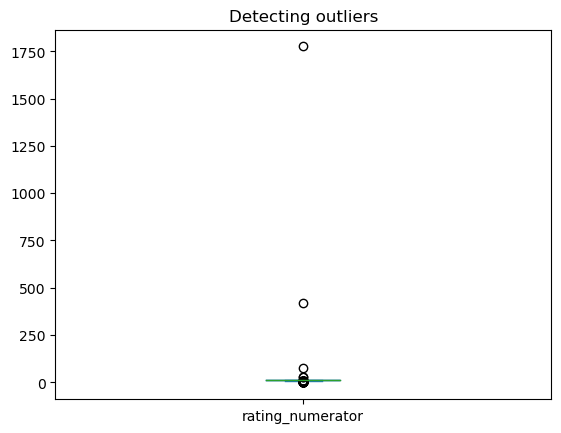

In [107]:
# Further explore exceptionally high rating_numerator values
df_twitter_master.rating_numerator.plot(kind='box')
plt.title('Detecting outliers')
plt.show()

**Observation from boxplot for rating_numerator:**
    
- rating_numerator values above 100 looks rather exceptional

In [108]:
# how many records for rating_numerator outliers do we have ?
df_twitter_master.query('rating_numerator >= 100')

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,cleantext,dog_stage,retweet_count,like_count,media_url,short_url,annotation,breed,jpg_url
274,670842764863651840,2015-11-29,Twitter for iPhone,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,NaN,After so many requests... here you go.\n\nGood dogg.,NaN,7405,21377,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,https://t.co/yfAAo1gdeY,NaN,NaN,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg
1311,749981277374128128,2016-07-04,TweetDeck,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,This is Atticus. He's quite simply America af.,NaN,2221,4672,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,https://t.co/GRXwMxLBkh,Atticus,NaN,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg


**Observation for rating_numerator outliers:**

- Dogs with numerator as outliers > 100, do have a high amount of retweet and like counts, it might be the most popular dogs so lets keep the records

### Insight questions to answer:

1. Which breeds are tweeted the most ?
2. Which breeds are the post popular ?
3. What is the tweet trent over time ?

### Insight 1: Which breeds are tweeted the most by their owners ?

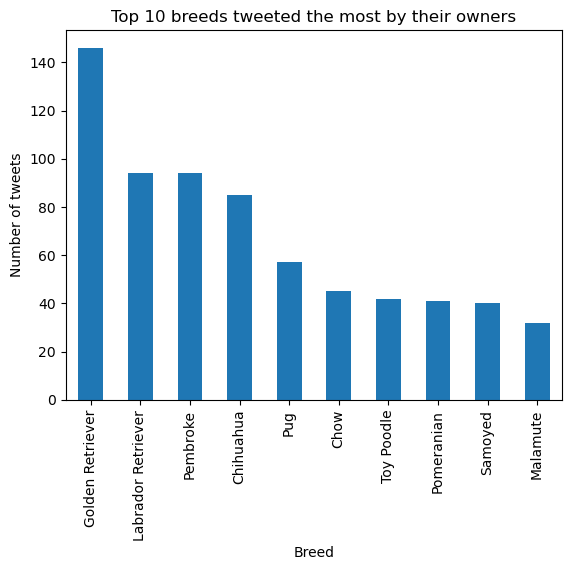

In [109]:
# Display the top 10 breeds that gets tweeted the most
df_twitter_master.breed.value_counts()[:10].plot(kind='bar')
plt.title('Top 10 breeds tweeted the most by their owners')
plt.xlabel('Breed')
plt.ylabel('Number of tweets')
plt.show()

### Insight  2: Which breeds are the post popular ?

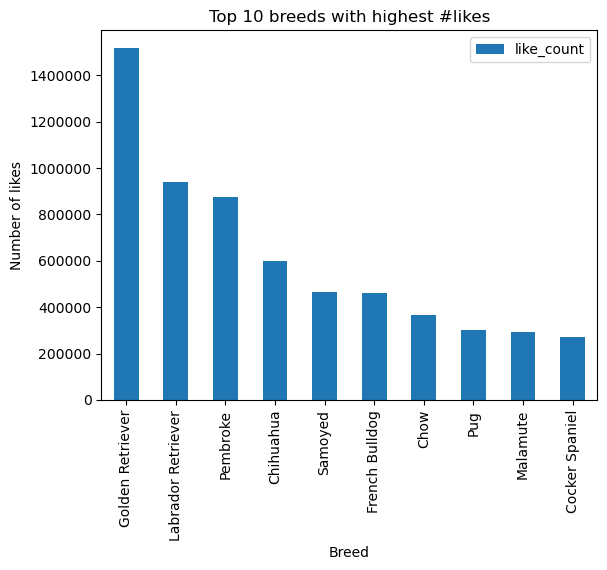

In [110]:
# Display the top 10 breeds with highest like counts
popular_breeds = df_twitter_master.groupby('breed', as_index=False)['like_count'].sum().sort_values(by='like_count', ascending=False, ignore_index=True)[:10]
ax1 = popular_breeds.plot(kind='bar', x='breed')

# turn off exponential formatting
ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Top 10 breeds with highest #likes')
plt.ylabel('Number of likes')
plt.xlabel('Breed')
plt.show()

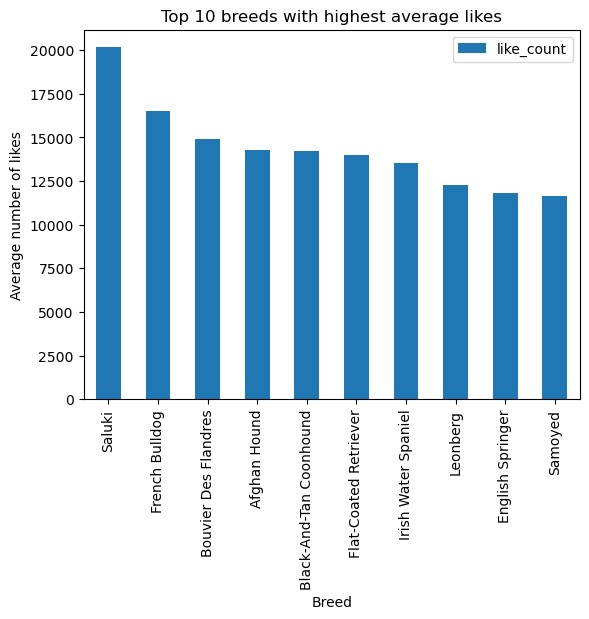

In [111]:
# Display the top 10 breeds with highest mean counts
popular_breeds = df_twitter_master.groupby('breed', as_index=False)['like_count'].mean().sort_values(by='like_count', ascending=False, ignore_index=True)[:10]
ax1 = popular_breeds.plot(kind='bar', x='breed')

# turn off exponential formatting
ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Top 10 breeds with highest average likes')
plt.ylabel('Average number of likes')
plt.xlabel('Breed')
plt.show()

### Insight 3: What is the tweet trent over time ?

In [112]:
# Create a time series dataset, to track the number of tweets per month
twitter_timeseries = df_twitter_master.filter(['timestamp', 'tweet_id'], axis=1).copy()

# set datetime field as index
twitter_timeseries.set_index('timestamp', inplace=True) 

twitter_timeseries.head()

,tweet_id
timestamp,
2015-11-15,666020888022790149
2015-11-15,666029285002620928
2015-11-15,666033412701032449
2015-11-16,666044226329800704
2015-11-16,666049248165822465


In [113]:
# calculate the mean tweets per month
freq = 'M'
twitter_timeseries = twitter_timeseries.resample(freq).count()
twitter_timeseries

,tweet_id
timestamp,
2015-11-30,295
2015-12-31,369
2016-01-31,181
2016-02-29,119
2016-03-31,129
2016-04-30,58
2016-05-31,58
2016-06-30,89
2016-07-31,94


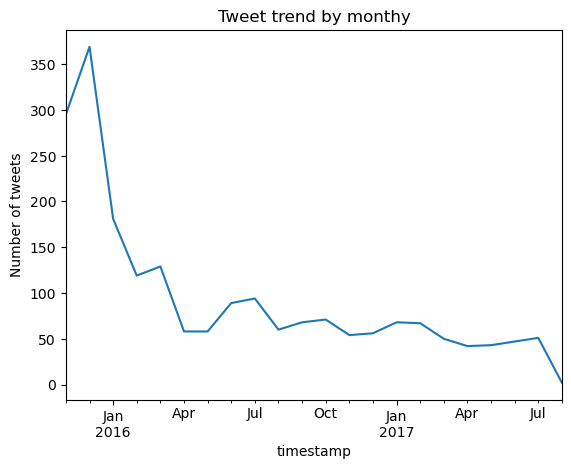

In [114]:
ax = twitter_timeseries.plot()
ax.get_legend().remove()
plt.title('Tweet trend by monthy')
plt.ylabel('Number of tweets')
plt.show()

### Insights:

**Insight 1: Which breeds are tweeted the most ?**
Owners of Golden Retrievers and Labradors tweet the most

**Insight 2: Which dog breeds are the post popular ?**
Be careful of Simpsons' Paradox, because the owners of labradors tweet the most, they also receive the most total likes. Bedlington Terrier and Saluki dog breeds receive the most average likes per breed

**Insight 3: What is the tweet trent over time ?**
There is downwards trend of number of tweets per month, from Nov 2015 to Oct 2017. The popularity of WeRateDogs seems to decline

### Visualization

Display profiles cards of the dog with the most likes in the top 5 breeds

In [115]:
# Make sure string fields to be used in the profile cards don't contain too much NaN
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2071 non-null   int64         
 1   timestamp           2071 non-null   datetime64[ns]
 2   source              2071 non-null   object        
 3   expanded_urls       2068 non-null   object        
 4   rating_numerator    2071 non-null   int64         
 5   rating_denominator  2071 non-null   int64         
 6   name                1380 non-null   object        
 7   cleantext           2064 non-null   object        
 8   dog_stage           368 non-null    object        
 9   retweet_count       2071 non-null   int64         
 10  like_count          2071 non-null   int64         
 11  media_url           1872 non-null   object        
 12  short_url           2068 non-null   object        
 13  annotation          1567 non-null   object      

In [116]:
# Feature engineering for better visualization
# Convert None values to 'Unknown' as it looks better on the 'profile' card
df_twitter_master['name'] = df_twitter_master['name'].fillna('unknown')
df_twitter_master['breed'] = df_twitter_master['breed'].fillna('unknown')
df_twitter_master['dog_stage'] = df_twitter_master['dog_stage'].fillna('unknown')
df_twitter_master['annotation'] = df_twitter_master['annotation'].fillna('')

In [117]:
# Select the most liked dog in the top average liked breeds
for breed in popular_breeds['breed'][:5]:

    # Select the most popular dog within the selected breed
    idx = df_twitter_master.query('breed == @breed')['like_count'].idxmax()
    best = df_twitter_master.loc[idx]

    display_image(best)

In [118]:
# just for fun, display the dog with the most tweets
idx = df_twitter_master.like_count.idxmax()
best = df_twitter_master.loc[idx]
display_image(best)

<a id='references'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [Font color in headings](https://stackoverflow.com/questions/4182554/html-css-font-color-vs-span-style)
- [Twitter documentation for get_tweets using V2](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets-id)
- [Twitter source code example for get_tweets using V2](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py)
- [reading a json file](https://knowledge.udacity.com/questions/66949#66975)
- [Twitter API v2, tweepy and pandas in Python](https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/)
- [How to handle dog stages](https://knowledge.udacity.com/questions/196883)
- [prevent exponential format when plotting](https://stackoverflow.com/questions/14711655/how-to-prevent-numbers-being-changed-to-exponential-form-in-a-plot)
- [How to display images and text together using HTML](https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output)

<a id='submission'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

- [Font color in headings](https://stackoverflow.com/questions/4182554/html-css-font-color-vs-span-style)
- [Twitter documentation for get_tweets using V2](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets-id)
- [Twitter source code example for get_tweets using V2](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py)
- [reading a json file](https://knowledge.udacity.com/questions/66949#66975)
- [Twitter API v2, tweepy and pandas in Python](https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/)
- [How to handle dog stages](https://knowledge.udacity.com/questions/196883)
- [prevent exponential format when plotting](https://stackoverflow.com/questions/14711655/how-to-prevent-numbers-being-changed-to-exponential-form-in-a-plot)
- [How to display images and text together using HTML](https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output)

<a id='submission'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

In [121]:
# convert notebook to html
os.system('jupyter nbconvert --to html wrangle_act.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook wrangle_act.ipynb to html
[NbConvertApp] Writing 1231032 bytes to wrangle_act.html


0